<a href="https://colab.research.google.com/github/BenjaminNgJL/dsa4212_assignment/blob/sinusoidal/loss_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

In [2]:
!git clone https://github.com/alexxthiery/char_transformer.git

Cloning into 'char_transformer'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 20 (delta 2), reused 2 (delta 2), pack-reused 17 (from 1)
Receiving objects: 100% (20/20), 30.14 MiB | 22.78 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
%cd char_transformer

/content/char_transformer


In [4]:
import os
import requests
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

import flax.linen as nn
from flax.linen import attention as attn

# local imports
import models.models as models
import util.generation as generation


In [5]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [6]:
test_url = "https://raw.githubusercontent.com/alexxthiery/char_transformer/afa30c8b3c2be8a40a96bdffd26da54e874e06de/data/text8_test.txt"
train_url = "https://raw.githubusercontent.com/alexxthiery/char_transformer/afa30c8b3c2be8a40a96bdffd26da54e874e06de/data/text8_train.txt"

# Download test data
test_text = requests.get(test_url).text
train_text = requests.get(train_url).text

print(test_text[:100])  # preview

be ejected and hold it there examine the chamber to ensure it is clear allow the action to go forwar


In [7]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
# with open("./data/text8_train.txt", "r") as f:
#     train_text = f.read()
# with open("./data/text8_test.txt", "r") as f:
#     test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [8]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [9]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [10]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

patibles operating systems the pillar bearing the arms of portugal erected by c o at cape st mary diogo c o or cam pron ipa was 

say the early christian scholars who inquired what was the true name of the god of the old testament had therefore no great diff

s royal saudi air force f one five pilots shot down two f four phantoms flown by the iranian air force in a border skirmish in o

dt baseball player one nine seven five sara gilbert american actress one nine seven nine sui feifei chinese basketball player on

itique des deux indes in collaboration with raynal one seven seven two one seven eight one voyage en hollande one seven seven th



# Create a basic Transformer model

In [11]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len, )
    # (sinusoidal, learned, rotary)

    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [12]:
# vocab size
vocab_size= len(char_set)

# internal model dimensions
d_model=256

# number of attention heads
n_heads=8

# number of Transformer layers
n_layers=2

# maximum sequence length
max_len=128

model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len)

In [13]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 1_624_576


In [14]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


# Loss function

In [15]:
# @jax.jit
# ### cross_entropy
# def loss_and_metrics(logits, targets):
#     """Compute cross-entropy loss and accuracy.

#     Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

#     Args:
#       logits: (B, T, V) float array of unnormalized scores.
#       targets: (B, T) integer array with ground-truth class ids.

#     Returns:
#       loss: scalar average cross-entropy over all positions.
#       metrics: dict with keys "loss" and "acc" (both scalars).
#     """
#     # Flatten batch/time dims so optax works on shape (N, V) and (N,)
#     vocab = logits.shape[-1]
#     flat_logits = logits.reshape(-1, vocab)
#     flat_targets = targets.reshape(-1)

#     # Per-position cross-entropy, then mean over all positions
#     per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
#     loss = per_pos.mean()

#     # prediction over all positions
#     preds = jnp.argmax(logits, axis=-1)  # (B, T)

#     # compute accuracy over only the last position
#     is_match = preds == targets

#     # Accuracy over all positions
#     acc_all = jnp.mean(is_match.astype(jnp.float32))

#     # Accuracy over only last position
#     acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

#     return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

In [30]:
@jax.jit
#  label-smoothed cross-entropy

def loss_and_metrics(logits, targets, epsilon=0.1):
    """Compute label-smoothed cross-entropy loss and accuracy."""
    vocab = logits.shape[-1]

    # Compute log-probabilities
    log_probs = jax.nn.log_softmax(logits, axis=-1)  # (B, T, V)

    # One-hot encode targets
    targets_onehot = jax.nn.one_hot(targets, vocab)  # (B, T, V)

    # Apply label smoothing:
    # q_i = (1 - ε) * one_hot + ε / V
    smoothed_targets = (1 - epsilon) * targets_onehot + epsilon / vocab

    # Cross-entropy: mean over batch and time
    loss = -jnp.sum(smoothed_targets * log_probs, axis=-1).mean()

    # Accuracy metrics
    preds = jnp.argmax(logits, axis=-1)
    is_match = preds == targets
    acc_all = jnp.mean(is_match.astype(jnp.float32))
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:, -1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}


In [31]:
# ## focal loss

# @jax.jit
# def loss_and_metrics(logits, targets, gamma: float = 2.0, alpha: float | None = None):
#     """
#     Focal loss for sequence modelling.
#     Args:
#       logits: (B, T, V)
#       targets: (B, T) int in [0, V-1]
#       gamma: focusing parameter (>0 → focus more on hard tokens)
#       alpha: optional class-balancing weight. If float in (0,1), it is applied
#              to the true class. If None, no α is used.

#     Returns:
#       loss: scalar focal loss averaged over all tokens
#       metrics: dict with loss, acc (all tokens), acc_last (last token per seq)
#     """
#     B, T, V = logits.shape

#     # log p and p
#     log_probs = jax.nn.log_softmax(logits, axis=-1)   # (B, T, V)
#     probs = jnp.exp(log_probs)                        # (B, T, V)

#     # gather p_y and log p_y for the true class
#     targets_exp = targets[..., None]                  # (B, T, 1)
#     p_t = jnp.take_along_axis(probs, targets_exp, axis=-1).squeeze(-1)      # (B, T)
#     log_p_t = jnp.take_along_axis(log_probs, targets_exp, axis=-1).squeeze(-1)  # (B, T)

#     # focal term: (1 - p_t)^gamma
#     focal_factor = (1.0 - p_t) ** gamma               # (B, T)

#     # optional alpha weighting
#     if alpha is not None:
#         # α for the true class only
#         alpha_t = jnp.full_like(p_t, alpha)
#         focal_loss = -alpha_t * focal_factor * log_p_t
#     else:
#         focal_loss = -focal_factor * log_p_t          # (B, T)

#     # mean over all tokens
#     loss = focal_loss.mean()

#     # metrics (same as before)
#     preds = jnp.argmax(logits, axis=-1)               # (B, T)
#     is_match = (preds == targets)
#     acc_all = is_match.astype(jnp.float32).mean()
#     acc_last = is_match.astype(jnp.float32)[:, -1].mean()

#     return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}


# Optimization step:

In [32]:
# create an update function
def train_step(params, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        # loss, metrics = loss_and_metrics(logits, y) #for cross_entropy
        loss, metrics = loss_and_metrics(logits, y, epsilon=0.1) #for label smoothing cross_entropy
        # loss, metrics = loss_and_metrics(logits, y, gamma=2.0) # for focal loss

        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

# Batch creation:

In [33]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [34]:
# define optax optimizer
learning_rate = 0.001


# Create Adam optimizer (Optax)
tx = optax.adam(learning_rate=learning_rate)
# Initialize optimizer state for current params
opt_state = tx.init(params)
print(f"Initialized optimizer: Adam lr={learning_rate}")



Initialized optimizer: Adam lr=0.001


In [35]:
#niter = 100_000

niter=2_000
B, T = 128, 32
loss_history = []
time_history = []
time_test_history = []
loss_test_history = []
time_start = time.time()
for it in range(niter):
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new
    acc = metrics['acc']
    acc_last = metrics['acc_last']
    loss = metrics['loss']

    loss_history.append(loss)
    time_history.append(time.time() - time_start)

    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start
        # compute loss on test set
        B_test, T_test = 1024, 32
        test_batch = get_batch(test_text_int, B_test, T_test)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits = model.apply({"params": params}, test_input)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
        test_acc = test_metrics['acc']
        test_acc_last = test_metrics['acc_last']
        loss_test_history.append(test_loss)
        time_test_history.append(time_since_start)
        print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
        print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
        print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
        print()


iteration 0  time: 3.1 seconds
	 	 loss(train :: test): 1.8790 :: 1.8833
	 	 accuracy (train :: test): 55.6% :: 55.0%
	 	 accuracy (last character) (train :: test): 54.7% :: 56.5%

iteration 40  time: 4.0 seconds
	 	 loss(train :: test): 1.7978 :: 1.8132
	 	 accuracy (train :: test): 54.9% :: 55.3%
	 	 accuracy (last character) (train :: test): 60.2% :: 59.9%

iteration 80  time: 4.7 seconds
	 	 loss(train :: test): 1.8114 :: 1.7928
	 	 accuracy (train :: test): 55.6% :: 56.2%
	 	 accuracy (last character) (train :: test): 56.2% :: 56.6%

iteration 120  time: 5.4 seconds
	 	 loss(train :: test): 1.8138 :: 1.8203
	 	 accuracy (train :: test): 55.2% :: 55.1%
	 	 accuracy (last character) (train :: test): 61.7% :: 58.8%

iteration 160  time: 6.1 seconds
	 	 loss(train :: test): 1.7894 :: 1.8070
	 	 accuracy (train :: test): 55.0% :: 55.4%
	 	 accuracy (last character) (train :: test): 57.8% :: 58.6%

iteration 200  time: 6.8 seconds
	 	 loss(train :: test): 1.8126 :: 1.8082
	 	 accuracy (

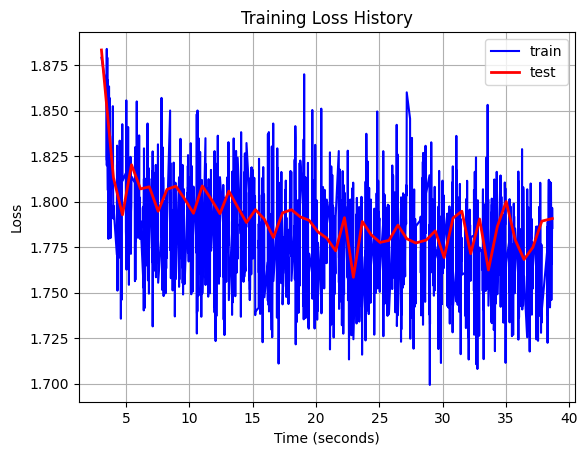

In [36]:
# plot the loss history
import matplotlib.pyplot as plt
plt.plot(time_history, loss_history, '-', label='train', color="blue")
plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

In [37]:
B = 1
seed = 42
rng = jax.random.PRNGKey(seed)
prompt = "hello my fri"
# prompt_int = encode(prompt.lower())
prompt_int = jnp.array([ [char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]] ], dtype=jnp.int32)

gen_len = 1000
out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64,
                          temperature=0.7, sample=True)
print('generated ids shape:', out_ids.shape)
print('generated text:')
generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# concatenate with prompt
print(prompt + generated_text)
#print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))

generated ids shape: (1, 1000)
generated text:
hello my friril sh aimo aselse sh a t athaclenithananananon panseenozesechn o cze chrd mumourulenoniat me icag peacosetra s ghous ric ay kedinany ges d on bounarsisteser toangonanolsur ugrarsekaly ibus ton s an mad appt fintona intaninkenemdopparyonthag s ong warctent aman fbaces h chonoupeman mas is chbrger ancusonos holans eaje tqtoloz arone pabouselila anpes eas ispeux ma arthil agoneserteanthesimacflinire aticonde shast es as ofin h aneseresirxin pch a neppinonigeanoidenanest isigomirtontent bes ah es l ka midengma s iced noousholarigofanemograr onorce anan jeusangj s s a giaphut f panus glerys o parseeconry is relidade arconanaurth aty s agie aratis toncorl alas alicheamitaskabior thng t shonerge char igabin ous bis itheparin acorarla s ordintse hdewacones dulkes as wosigerarinendhar tia panawarepa se ang tialy t apor p dderrdar tharyponos m eqse lidolatt tongesme ch s h argaciquwais oryr onar hoveanearer aicatitan t steses misoyearav